<a href="https://colab.research.google.com/github/dhanushka365/LSTM-AutoEncoders/blob/main/LSTM_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt 
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from keras.models import Model
import seaborn as sns
import sys

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Start date is: 2021-06-16 00:00:00
End date is: 2022-06-16 00:00:00


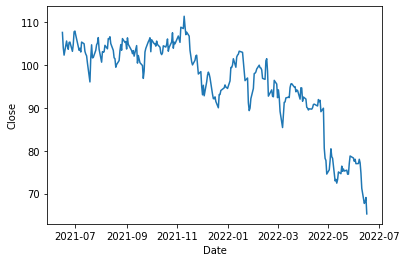

In [4]:
#Load the sequence data from csv
dataframe = pd.read_csv('/content/drive/MyDrive/Anomaly/GE.csv')
df = dataframe[['Date', 'Close']]
df['Date']=pd.to_datetime(df['Date'])

sns.lineplot(x=df['Date'],y=df['Close'])
print("Start date is:", df['Date'].min())
print("End date is:", df['Date'].max())


In [12]:
train, test =df.loc[df['Date'] <= '2021-11-30'], df.loc[df['Date'] >'2021-11-30']

scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])

train['Close']= scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [23]:
seq_size = 30

def to_sequences(x , y , seq_size=1):
  x_values = []
  y_values = []

  for i in range(len(x)-seq_size):
    x_values.append(x.iloc[i:(i+seq_size)].values)
    y_values.append(y.iloc[i+seq_size])

  return np.array(x_values),np.array(y_values)

trainX , trainY = to_sequences(train[['Close']], train['Close'], seq_size)
testX , testY = to_sequences(test[['Close']], test['Close'], seq_size)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 128)               66560     
                                                                 
 dropout_20 (Dropout)        (None, 128)               0         
                                                                 
 repeat_vector_10 (RepeatVec  (None, 30, 128)          0         
 tor)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 30, 128)           0         
                                                                 
 time_distributed_10 (TimeDi  (None, 30, 1)            129       
 stributed)                                                      
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-tra

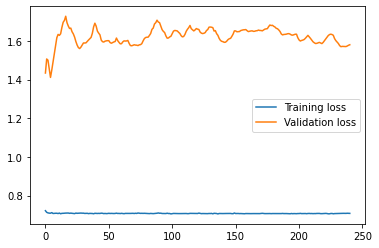

In [29]:
model = Sequential()
model.add(LSTM(128 , input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(rate=0.2))

model.add(RepeatVector(trainX.shape[1]))

model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(trainX.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

history = model.fit(trainX, trainY, epochs=241, batch_size=32, validation_split=0.1,verbose=1)

plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()